# AIC, Junction and characterization of the gaussian components of each spectrum

In this notebook, we apply criteria to choose the gaussian components that best represent each spectrum, using the AIC criterion, and then separate into physically relevant components. **This notebook is for the case where we mask channels.**

We have the following:
- **We make a mask where 1 indicates the pixel where we must use the fit that masks the filtered-out channels. This mask is done manually after observing the spectra.**

**NEW: the mask is now defined using a radius of 0.8 arcsec**
Previous criteria: if the peak of the spectrum falls in the masked-out channels, we must use the fit that has all channels in it. This will be mostly for the regions > 500 au from the protostar. We apply the AIC criterion to determine, for those regions, if 1 Gaussian or 2 Gaussians are best.
- Then, for all the rest we should use AIC criterion to determine the best fit, where the fit is done using only the unmasked channels.
- We join in a file all the fits that have the same number of components, independant if they were fitted with masked channels or not, after the AIC criterion (one file for 1 Gaussian, another for 2 Gaussians and a third for 3 Gaussians)
- **We use clustering algorithms to detect the different physical components in a simulated cube** that is made with the best fits. We use the Gaussian fit properties as features for unsupervised learning. This gives us several components separated in ppv space.
- We recognize the main components of the emission, which we think is envelope infall (ask for models to confirm this), and save the blueshifted and redshifted parts separately..


In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import pyspeckit
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
import os
import sys
sys.path.append('../../../')
sys.path.append('../')
from B5setup import *
from AICfunc import *
from astropy.modeling import models
from spectral_cube import SpectralCube
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import hdbscan
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from copy import copy
from astropy.modeling.models import Gaussian1D

In [2]:
cubefile = '../all_chans/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected'
cubefile_chanmasked = '../central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_masked'

fitfile1G = cubefile + '_1G_fitparams_2_filtered.fits'
fitfile2G = cubefile + '_2G_fitparams_2_filtered.fits'
fitfile3G = cubefile + '_3G_fitparams_2_filtered.fits'

fitfile1G_chanmasked = cubefile_chanmasked[:len(cubefile_chanmasked)-7] + '_1G_fitparams_2_filtered.fits'
fitfile2G_chanmasked = cubefile_chanmasked[:len(cubefile_chanmasked)-7] + '_2G_fitparams_2_filtered.fits'
fitfile3G_chanmasked = cubefile_chanmasked[:len(cubefile_chanmasked)-7] + '_3G_fitparams_2_filtered.fits'

mask2dfile = '../B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_mask.fits'
rmsfile = '../B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_rms.fits'
snrfile = '../B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_snr.fits'

radiusmask = 0.8 #* u.arcsec

blue_env_paramsfile = 'components_blueshifted_envelope.fits'
flag_blue_env_file = 'components_blueshifted_envelope_flag_repeated.fits'
red_env_paramsfile = 'components_redshifted_envelope.fits'
flag_red_env_file = 'components_redshifted_envelope_flag_repeated.fits'
# as we only need the components, I left all the aic evaluation under a False statement so it does not run
evaluate_aic = True
test_normal_fit_existance = False
# This is to run the tests of features
run_dbscan = False
run_hdbscan = False

In [3]:
cubenormal = SpectralCube.read(cubefile+'.fits')
cubechanmasked = SpectralCube.read(cubefile_chanmasked+'.fits')
mask2d = fits.getdata(mask2dfile)
rmsmap = fits.getdata(rmsfile)
# where extended emission is dominant
velinit_zero = 9.7 * u.km/u.s
velend_zero = 10.3 * u.km/u.s

## Build mask with pixels where we need to mask to fit

In [4]:
fitwithfilteroutname = 'mask_H2CO_filteredoutchans_radius.fits'
if not os.path.exists(fitwithfilteroutname):
    print('Creating mask for filtered channels')
    header_fitwithfilterout = fits.getheader(mask2dfile)
    wcs = WCS(header_fitwithfilterout)
    centerx, centery = wcs.all_world2pix(ra_yso, dec_yso,0)
    radiusmaskpix = radiusmask/3600 / np.abs(header_fitwithfilterout['CDELT2'])
    mask_fitwithfilterout = np.zeros(np.shape(mask2d))
    yy, xx = np.mgrid[:len(mask_fitwithfilterout), :len(mask_fitwithfilterout[0])]
    mask_fitwithfilterout[np.where(distancepix(xx, yy, centerx, centery)<=radiusmaskpix)] = 1
    fits.writeto(fitwithfilteroutname, mask_fitwithfilterout, header_fitwithfilterout)
else:
    mask_fitwithfilterout = fits.getdata(fitwithfilteroutname)
    header_fitwithfilterout = fits.getheader(fitwithfilteroutname)
    print(fitwithfilteroutname+' already exists. Loaded.')



mask_H2CO_filteredoutchans_radius.fits already exists. Loaded.


## AIC determination of the best fit where we use all channels

1, 2 and 3 Gaussian fits exist in pixels where we use all channels to fit, so we will have to evaluate the AIC in all of them.

In [5]:
ncomponentsfile = '../all_chans/ncomponents_allchans.fits'
ncomponentsflagfile = '../all_chans/ncomponents_allchans_flag.fits'
aiccubefile = '../all_chans/aic_values_allchans.fits'

if evaluate_aic:
    params1Gnormal = fits.getdata(fitfile1G)
    params2Gnormal = fits.getdata(fitfile2G)
    params3Gnormal = fits.getdata(fitfile3G)

    if not os.path.exists(ncomponentsfile):
        mask_normal = ~mask_fitwithfilterout.astype(bool) * mask2d.astype(bool)

        if test_normal_fit_existance:

            params1Gexist = np.nansum(params1Gnormal, axis=0).astype(bool) * mask_normal
            params2Gexist = np.nansum(params2Gnormal, axis=0).astype(bool) * mask_normal
            params3Gexist = np.nansum(params3Gnormal, axis=0).astype(bool) * mask_normal

            print('Normal fit has 1G fits: '+np.any(params1Gexist>0))
            print('Normal fit has 2G fits: '+np.any(params2Gexist>0))
            print('Normal fit has 3G fits: '+np.any(params3Gexist>0))

        spc1G = pyspeckit.Cube(cube=cubenormal, mask=mask_normal)
        spc2G = pyspeckit.Cube(cube=cubenormal, mask=mask_normal)
        spc3G = pyspeckit.Cube(cube=cubenormal, mask=mask_normal)

        spc1G.load_model_fit(fitfile1G, npars=3, npeaks=1, fittype='gaussian')
        spc2G.load_model_fit(fitfile2G, npars=3, npeaks=2, fittype='gaussian')
        spc3G.load_model_fit(fitfile3G, npars=3, npeaks=3, fittype='gaussian')

        fittedmodel1G = spc1G.get_modelcube()
        fittedmodel2G = spc2G.get_modelcube()
        fittedmodel3G = spc3G.get_modelcube()

        results_aic = get_AIC_for_cube(cubenormal, rmsmap, mask_normal, 
                                       [fittedmodel1G, fittedmodel2G, fittedmodel3G], 
                                       nfittedmodels=3, nparamsfittedmodels=[3, 6, 9])

        fits.writeto(ncomponentsfile, results_aic[0], header_fitwithfilterout)
        fits.writeto(ncomponentsflagfile, results_aic[1], header_fitwithfilterout)
        fits.writeto(aiccubefile, results_aic[2])

    else:
        results_aic = (fits.getdata(ncomponentsfile), fits.getdata(ncomponentsflagfile))
        print(ncomponentsfile + ' and ' + ncomponentsflagfile + ' already exists. Loaded.')

    if not os.path.exists(fitfile1G[:-5]+'_aicres.fits'):
        header_params1gaic = fits.getheader(fitfile1G)
        params1Gnormalaic = get_aic_filtered_params(params1Gnormal, 1, results_aic[0])
        fits.writeto(fitfile1G[:-5]+'_aicres.fits', params1Gnormalaic, header_params1gaic)

    else:
        params1Gnormalaic = fits.getdata(fitfile1G[:-5]+'_aicres.fits')
        header_params1gaic = fits.getheader(fitfile1G[:-5]+'_aicres.fits')
        print(fitfile1G[:-5]+'_aicres.fits already exists. Loaded.')  

    if not os.path.exists(fitfile2G[:-5]+'_aicres.fits'):
        header_params2gaic = fits.getheader(fitfile2G)
        params2Gnormalaic = get_aic_filtered_params(params2Gnormal, 2, results_aic[0])
        fits.writeto(fitfile2G[:-5]+'_aicres.fits', params2Gnormalaic, header_params2gaic)

    else:
        header_params2gaic = fits.getheader(fitfile2G[:-5]+'_aicres.fits')
        params2Gnormalaic = fits.getdata(fitfile2G[:-5]+'_aicres.fits')
        print(fitfile2G[:-5]+'_aicres.fits already exists. Loaded.')  


    if not os.path.exists(fitfile3G[:-5]+'_aicres.fits'):
        header_params3gaic = fits.getheader(fitfile3G)
        params3Gnormalaic = get_aic_filtered_params(params3Gnormal, 3, results_aic[0])
        fits.writeto(fitfile3G[:-5]+'_aicres.fits', params3Gnormalaic, header_params3gaic)
    else:
        header_params3gaic = fits.getheader(fitfile3G[:-5]+'_aicres.fits')
        params3Gnormalaic = fits.getdata(fitfile3G[:-5]+'_aicres.fits')
        print(fitfile3G[:-5]+'_aicres.fits already exists. Loaded.')  

    # if not os.path.exists(cubefile[13:]+'_peakinmaskedchans_ncomponents.fits'):
    #     fits.writeto(cubefile[13:]+'_peakinmaskedchans_ncomponents.fits', results_aic[0], header_peakisinchanmasked)
    # else:
    #     print(cubefile[13:]+'_peakinmaskedchans_ncomponents.fits already exists.')

    # if not os.path.exists(cubefile[13:]+'_peakinmaskedchans_flag.fits'):
    #     fits.writeto(cubefile[13:]+'_peakinmaskedchans_flag.fits', results_aic[1], header_peakisinchanmasked)
    # else:
    #     print(cubefile[13:]+'_peakinmaskedchans_flag.fits already exists.')

../all_chans/ncomponents_allchans.fits and ../all_chans/ncomponents_allchans_flag.fits already exists. Loaded.
../all_chans/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_2_filtered_aicres.fits already exists. Loaded.
../all_chans/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_2G_fitparams_2_filtered_aicres.fits already exists. Loaded.
../all_chans/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_3G_fitparams_2_filtered_aicres.fits already exists. Loaded.


We have that most of the pixels are well fitted by one Gaussian component. Some pixels which are at the edge of the blueshifted and redshifted southern edge have a flag.

Now we save the components in the all_chans folder

I checked the results and I trust them too. Maybe not all components will be used in the case of the 2G fit.

## AIC determination of the best fit where we mask channels

In [6]:
ncomponentsfilec = '../central_chans_masked/ncomponents_allchans.fits'
ncomponentsflagfilec = '../central_chans_masked/ncomponents_allchans_flag.fits'
aiccubefilec = '../central_chans_masked/aic_values_allchans.fits'
if evaluate_aic:
    params1Gchanmasked = fits.getdata(fitfile1G_chanmasked)
    params2Gchanmasked = fits.getdata(fitfile2G_chanmasked)
    params3Gchanmasked = fits.getdata(fitfile3G_chanmasked)

    if not os.path.exists(ncomponentsfilec):
        params1Gchanmasked = fits.getdata(fitfile1G_chanmasked)
        params2Gchanmasked = fits.getdata(fitfile2G_chanmasked)
        params3Gchanmasked = fits.getdata(fitfile3G_chanmasked)

        spc1G_chanmasked = pyspeckit.Cube(cube=cubechanmasked, mask=mask_fitwithfilterout)
        spc2G_chanmasked = pyspeckit.Cube(cube=cubechanmasked, mask=mask_fitwithfilterout)
        spc3G_chanmasked = pyspeckit.Cube(cube=cubechanmasked, mask=mask_fitwithfilterout)

        spc1G_chanmasked.load_model_fit(fitfile1G_chanmasked, npars=3, npeaks=1, fittype='gaussian')
        spc2G_chanmasked.load_model_fit(fitfile2G_chanmasked, npars=3, npeaks=2, fittype='gaussian')
        spc3G_chanmasked.load_model_fit(fitfile3G_chanmasked, npars=3, npeaks=3, fittype='gaussian')

        fittedmodel1G_chanmasked = spc1G_chanmasked.get_modelcube()
        fittedmodel2G_chanmasked = spc2G_chanmasked.get_modelcube()
        fittedmodel3G_chanmasked = spc3G_chanmasked.get_modelcube()

        results_aic_chamasked = get_AIC_for_cube(cubechanmasked, rmsmap, mask_fitwithfilterout,
                                                 [fittedmodel1G_chanmasked, fittedmodel2G_chanmasked, fittedmodel3G_chanmasked])


        fits.writeto(ncomponentsfilec, results_aic_chamasked[0], header_fitwithfilterout)
        fits.writeto(ncomponentsflagfilec, results_aic_chamasked[1], header_fitwithfilterout)
        fits.writeto(aiccubefilec, results_aic_chamasked[2])

    else:
        results_aic_chamasked = fits.getdata(ncomponentsfilec), fits.getdata(ncomponentsflagfilec)
        print(ncomponentsfilec+' and ' + ncomponentsflagfilec+' already exist. Loaded.')

    if not os.path.exists(fitfile1G_chanmasked[:-5]+'_aicres.fits'):
        header_params1gaic = fits.getheader(fitfile1G_chanmasked)
        params1Gchanmaskedaic = get_aic_filtered_params(params1Gchanmasked, 1, results_aic_chamasked[0])
        fits.writeto(fitfile1G_chanmasked[:-5]+'_aicres.fits', params1Gchanmaskedaic, header_params1gaic)
    else:
        header_params1gaic = fits.getheader(fitfile1G_chanmasked[:-5]+'_aicres.fits')
        params1Gchanmaskedaic = fits.getdata(fitfile1G_chanmasked[:-5]+'_aicres.fits')
        print(fitfile1G_chanmasked[:-5]+'_aicres.fits already exists. Loaded.')        

    if not os.path.exists(fitfile2G_chanmasked[:-5]+'_aicres.fits'):
        header_params2gaic = fits.getheader(fitfile2G_chanmasked)
        params2Gchanmaskedaic = get_aic_filtered_params(params2Gchanmasked, 2, results_aic_chamasked[0])
        fits.writeto(fitfile2G_chanmasked[:-5]+'_aicres.fits', params2Gchanmaskedaic, header_params2gaic)
    else:
        header_params2gaic = fits.getheader(fitfile2G_chanmasked[:-5]+'_aicres.fits')
        params2Gchanmaskedaic = fits.getdata(fitfile2G_chanmasked[:-5]+'_aicres.fits')
        print(fitfile2G_chanmasked[:-5]+'_aicres.fits already exists. Loaded.')   


    if not os.path.exists(fitfile3G_chanmasked[:-5]+'_aicres.fits'):
        header_params3gaic = fits.getheader(fitfile3G_chanmasked)
        params3Gchanmaskedaic = get_aic_filtered_params(params3Gchanmasked, 3, results_aic_chamasked[0])
        fits.writeto(fitfile3G_chanmasked[:-5]+'_aicres.fits', params3Gchanmaskedaic, header_params3gaic)
    else:
        header_params3gaic = fits.getheader(fitfile3G_chanmasked[:-5]+'_aicres.fits')
        params3Gchanmaskedaic = fits.getdata(fitfile3G_chanmasked[:-5]+'_aicres.fits')
        print(fitfile3G_chanmasked[:-5]+'_aicres.fits already exists. Loaded.')   

../central_chans_masked/ncomponents_allchans.fits and ../central_chans_masked/ncomponents_allchans_flag.fits already exist. Loaded.
../central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_2_filtered_aicres.fits already exists. Loaded.
../central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_2G_fitparams_2_filtered_aicres.fits already exists. Loaded.
../central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_3G_fitparams_2_filtered_aicres.fits already exists. Loaded.


Now we save the results in 3 .fits files

## Joining the 1G, 2G and 3G that had channels masked and not

We put all the 1 Gaussian fits that passed the AIC test together, both the ones from the masked channels fit and the all channels fit, to see if there is a continuum.

In [7]:
fitfile1Gtotalaic = cubefile[13:] + '_1G_fitparams_total_aicres.fits'
fitfile2Gtotalaic = cubefile[13:] + '_2G_fitparams_total_aicres.fits'
fitfile3Gtotalaic = cubefile[13:] + '_3G_fitparams_total_aicres.fits'
fitfiletotalncomp = cubefile[13:] + '_total_ncomponents.fits'

In [8]:
if evaluate_aic:

    if not os.path.exists(fitfile1Gtotalaic):
        params1Gtotalaic = np.nansum([params1Gnormalaic, params1Gchanmaskedaic], axis=0)
        params1Gtotalaic[np.where(params1Gtotalaic==0)] = np.nan
        fits.writeto(fitfile1Gtotalaic, params1Gtotalaic, header_params1gaic)
    else:
        params1Gtotalaic = fits.getdata(fitfile1Gtotalaic)
        print(fitfile1Gtotalaic+' already exists. Loaded.')  

    if not os.path.exists(fitfile2Gtotalaic):
        params2Gtotalaic = np.nansum([params2Gnormalaic, params2Gchanmaskedaic], axis=0)
        params2Gtotalaic[np.where(params2Gtotalaic==0)] = np.nan
        fits.writeto(fitfile2Gtotalaic, params2Gtotalaic, header_params2gaic)
    else:
        params2Gtotalaic = fits.getdata(fitfile2Gtotalaic)
        print(fitfile2Gtotalaic+' already exists.') 

    if not os.path.exists(fitfile3Gtotalaic):
        params3Gtotalaic = np.nansum([params3Gnormalaic, params3Gchanmaskedaic], axis=0)
        params3Gtotalaic[np.where(params3Gtotalaic==0)] = np.nan
        fits.writeto(fitfile3Gtotalaic, params3Gtotalaic, header_params3gaic)
    else:
        params3Gtotalaic = fits.getdata(fitfile3Gtotalaic)
        print(fitfile3Gtotalaic+' already exists.') 
        
    if not os.path.exists(fitfiletotalncomp):
        ncomponents = np.nansum([results_aic_chamasked[0], results_aic[0]], axis=0)
        ncomponents[np.where(ncomponents==0)] = np.nan
        fits.writeto(fitfiletotalncomp, ncomponents, header_fitwithfilterout)
    else:
        ncomponents = fits.getdata(fitfiletotalncomp)
        print(fitfiletotalncomp+' already exists.') 

    # I want to check the pixels where there are no fits available
    paramsmissingfile = 'B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_paramsmissing.fits'
    if not os.path.exists(paramsmissingfile):
        snrmap = fits.getdata(snrfile)
        paramsmissing = np.where(np.isnan(params1Gtotalaic[0]),1,0) * np.where(np.isnan(params2Gtotalaic[0]),1,0) * np.where(np.isnan(params3Gtotalaic[0]),1,0) * (snrmap>5) * mask2d
        headermissing = fits.getheader(mask2dfile)
        fits.writeto(paramsmissingfile, paramsmissing, headermissing)
    else:
        paramsmissing = fits.getdata(paramsmissingfile)
        print(paramsmissingfile+' already exists.') 

Notes:
- Check if there is a new jump in velocities
- Now instead of a jump in velocities, we have two components (one located in the problematic channels and one blueshifted). There is still a jump in velocities with respect to the more blueshifted one, but that might be because the more redshifted part begins before and the fit does not recognize it
- For the region around 3:47:41.64, +32:51:45.02, and also the one around 3:47:41.71, +32:51:43.9, the most blueshifted component of the 2G fit is consistent with the blueshifted envelope
- In the region around 3:47:41.77 +32:51:41.2 (south tail), the more redshifted components is the continuation of the blueshifted envelope (the one that has best continuity). After further analysis we see that this component  **bridges** both envelopes.
- The part going up from the southern tail is ambiguous, I think that because of this we will need to do a manual selection



Old criteria Notes:

- Inside of the 1G fit of the central_chans_masked, at 3:47:41.6799+32:51:43.796 (more or less), after AIC, there is a jump in velocities. This is because the 2G fit in those regions had a very high uncertainty in the central position, so it did not pass the quality assessment. This is a jump of 0.26 km/s more or less. 

- In the 1G fit, when we unite the ones that mask channels and those who do not, there is a boundary where there is a jump with a minimum of 0.06 and maximum of 0.3 km/s. This does not seem to be very important. This is because of the transition between non-masked channels and masked channels



## Separating components that can be related to each other physically
There are two regions that complicate making a simple criteria separation: 

1. At the southern blueshifted part there is a "fork", two components, one ore blueshifted that has a high velocity gradient but is disconnected from the envelope, and a part that is connected that is redshifted and also connects to the redshifted envelope at some point. One part of the one that has a redshifted v gradient must be part of the blueshifted envelope but not all, and the boundary is not obvious
2. The part around the protostar is complicated. Down to which distance can we connect to the envelope?

- Make a criteria based on continuity? For the blueshifted side, choose from the 1G 
- We can use the same criteria as before but adding a ymax to add v>10 km/s to the blueshifted side? not really
- We will need to do by regions, probably.
- We will test if DBSCAN or HDBSCAN can give us some answers




In [9]:
all_components_filename = cubefile[13:] + '_components_total_aicres.fits'

if not os.path.exists(all_components_filename):
    # params_blueshiftedenv = np.zeros(np.shape(params1Gtotalaic)) * np.nan

    components = np.array([params1Gtotalaic, np.concatenate([params2Gtotalaic[:3], params2Gtotalaic[6:9]]),
                          np.concatenate([params2Gtotalaic[3:6], params2Gtotalaic[9:]]),
                          np.concatenate([params3Gtotalaic[:3], params3Gtotalaic[9:12]]),
                          np.concatenate([params3Gtotalaic[3:6], params3Gtotalaic[12:15]]),
                          np.concatenate([params3Gtotalaic[6:9], params3Gtotalaic[15:]])]) # this includes their uncertainties

    fits.writeto(all_components_filename, components, header_params1gaic)
else:
    components = fits.getdata(all_components_filename)


In [10]:
paramheader = fits.getheader(fitfile1Gtotalaic)
# each parameter has 6 dimensions, because it includes the errors.
xarray = np.linspace(0,paramheader['NAXIS1']-1, paramheader['NAXIS1'])
yarray = np.linspace(0,paramheader['NAXIS2']-1, paramheader['NAXIS2'])
xx, yy = np.meshgrid(xarray, yarray)
params = np.concatenate(components[:, :3], axis=0) 
errors_params = np.concatenate(components[:, 3:], axis=0) 
amplitudes = params[::3].flatten()
e_amplitudes = errors_params[::3].flatten()
cent_velocities = params[1::3].flatten()
e_cent_velocities = errors_params[1::3].flatten()
sigma_vs = params[2::3].flatten()
e_sigma_vs = errors_params[2::3].flatten()
xx_params = np.array([xx, xx, xx, xx, xx, xx])
yy_params = np.array([yy, yy, yy, yy, yy, yy])
xx_props = xx_params.flatten()
yy_props = yy_params.flatten()

In [11]:
# we select the data that are not nan to have our list of features
index_stay = np.where(~np.isnan(amplitudes))
amplitudes = amplitudes[index_stay]
e_amplitudes = e_amplitudes[index_stay]
cent_velocities = cent_velocities[index_stay]
e_cent_velocities = e_cent_velocities[index_stay]
sigma_vs = sigma_vs[index_stay]
e_sigma_vs = e_sigma_vs[index_stay]
xx_props = xx_props[index_stay]
yy_props = yy_props[index_stay]

In [12]:
# we will do a bit of EDA 
ds_feats = pd.DataFrame(data=np.transpose([xx_props, yy_props, amplitudes, cent_velocities, sigma_vs]), 
                        columns=['x_pix', 'y_pix', 'amplitude', 'vlsr', 'sigma_v'])



In [13]:
# # This is just a general exploration
# sns.pairplot(ds_feats, kind='kde',diag_kind = 'kde', corner=True)
# plt.savefig('corner_plot.pdf')
# # from this, maybe adding the amplitude could help

### DBSCAN


#### All features used

In [14]:
if run_dbscan:
    scaler = StandardScaler()
    features = np.transpose([xx_props, yy_props, amplitudes, cent_velocities, sigma_vs])
    X = scaler.fit_transform(features)
    db = DBSCAN(eps=0.5, min_samples=80)
    
    db.fit(X)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Total number of points: %d" % len(labels))

    unique_labels = set(labels)
    colors = [plt.cm.Set1(each) for each in np.linspace(0, 1, len(unique_labels))]


    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('vel')

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]


        class_member_mask = labels == k

        xy = scaler.inverse_transform(X[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,3], color=col, alpha=0.2)

#### Only x, y and velocity

In [15]:
if run_dbscan:
    scaler2 = StandardScaler()
    features2 = np.transpose([xx_props, yy_props, cent_velocities])
    X2 = scaler2.fit_transform(features2)
    nneigh = 100
    neighbors = NearestNeighbors(n_neighbors=nneigh)
    neighbors.fit(X2)
    distances, indices = neighbors.kneighbors(X2)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(distances, label=str(nneigh))
    ax.set_xlabel('Points sorted by k-distance')
    ax.set_ylabel('Average distance to k='+str(nneigh)+' nearest neighbors')

In [16]:
if run_dbscan:
    db2 = DBSCAN(eps=0.253, min_samples=100)
    db2.fit(X2)
    labels2 = db2.labels_
    n_clusters_2 = len(set(labels2)) - (1 if -1 in labels2 else 0)
    n_noise_2 = list(labels2).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_2)
    print("Estimated number of noise points: %d" % n_noise_2)
    print("Total number of points: %d" % len(labels2))

    unique_labels2 = set(labels2)
    colors2 = [plt.cm.tab20(each) for each in np.linspace(0, 1, len(unique_labels2))]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('vel')

    for k, col in zip(unique_labels2, colors2):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            continue

        class_member_mask = labels2 == k

        xy = scaler2.inverse_transform(X2[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,2], color=col, alpha=0.2, label=k)
    ax.legend()

#### x, y, vel and sigma

In [17]:
# test the curve with 4 parameters
if run_dbscan:
    scaler3 = StandardScaler()
    features3 = np.transpose([xx_props, yy_props, cent_velocities, sigma_vs])
    X3 = scaler3.fit_transform(features3)
    nneigh = 50
    neighbors = NearestNeighbors(n_neighbors=nneigh)
    neighbors.fit(X3)
    distances, indices = neighbors.kneighbors(X3)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(distances)
    ax.set_xlabel('Points sorted by k-distance')
    ax.set_ylabel('Average distance to k='+str(nneigh)+' nearest neighbors')

In [18]:
if run_dbscan:
    
    db3 = DBSCAN(eps=0.25, min_samples=nneigh)
    db3.fit(X3)
    labels3 = db3.labels_
    n_clusters_3 = len(set(labels3)) - (1 if -1 in labels3 else 0)
    n_noise_3 = list(labels3).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_3)
    print("Estimated number of noise points: %d" % n_noise_3)
    print("Total number of points: %d" % len(labels3))

    unique_labels3 = set(labels3)
    colors3 = [plt.cm.tab20(each) for each in np.linspace(0, 1, len(unique_labels3))]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('vel')

    for k, col in zip(unique_labels3, colors3):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels3 == k

        xy = scaler3.inverse_transform(X3[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,2], color=col, alpha=0.2, label=k)
    ax.legend()

#### x, y, amplitude and vel

In [19]:
# test the curve with 4 parameters
if run_dbscan:
    scaler4 = StandardScaler()
    features4 = np.transpose([xx_props, yy_props, amplitudes, cent_velocities])
    X4 = scaler4.fit_transform(features4)
    neighbors = NearestNeighbors(n_neighbors=200)
    neighbors.fit(X4)
    distances, indices = neighbors.kneighbors(X4)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(distances)
    ax.set_xlabel('Points sorted by k-distance')
    ax.set_ylabel('Average distance to k=40 nearest neighbors')

In [20]:
if run_dbscan:
    
    db4 = DBSCAN(eps=0.525, min_samples=200)
    db4.fit(X4)
    labels4 = db4.labels_
    n_clusters_4 = len(set(labels4)) - (1 if -1 in labels4 else 0)
    n_noise_4 = list(labels4).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_4)
    print("Estimated number of noise points: %d" % n_noise_4)
    print("Total number of points: %d" % len(labels4))

    unique_labels4 = set(labels4)
    colors4 = [plt.cm.tab20(each) for each in np.linspace(0, 1, len(unique_labels4))]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('vel')

    for k, col in zip(unique_labels4, colors4):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            # continue

        class_member_mask = labels4 == k

        xy = scaler4.inverse_transform(X4[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,3], color=col, alpha=0.2, label=k)
    ax.legend()

### HDBSCAN

#### All features

In [21]:
if run_hdbscan:
    scaler = StandardScaler()
    features = np.transpose([xx_props, yy_props, amplitudes, cent_velocities, sigma_vs])
    X = scaler.fit_transform(features)
    hdb = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=20)
    hdb.fit(X)
    labels = hdb.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    colors = [plt.cm.Set2(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Total number of points: %d" % len(labels))

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('vel')

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            


        class_member_mask = labels == k

        xy = scaler.inverse_transform(X[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,3], color=col, alpha=0.2)


In [22]:
# fig = plt.figure()
# hdb.condensed_tree_.plot(select_clusters=True,selection_palette=colors)

#### Only x, y and vel

In [23]:
if run_hdbscan:
    scaler2 = StandardScaler()
    features2 = np.transpose([xx_props, yy_props, cent_velocities])
    X2 = scaler2.fit_transform(features2)
    hdb2 = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=4, cluster_selection_epsilon=0.)
    hdb2.fit(X2)
    labels2 = hdb2.labels_
    n_clusters_2 = len(set(labels2)) - (1 if -1 in labels2 else 0)
    n_noise_2 = list(labels2).count(-1)

    unique_labels2 = set(labels2)
    colors2 = [plt.cm.Set2(each) for each in np.linspace(0, 1, len(unique_labels2))]
    
    print("Estimated number of clusters: %d" % n_clusters_2)
    print("Estimated number of noise points: %d" % n_noise_2)
    print("Total number of points: %d" % len(labels2))

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('vel')

    for k, col in zip(unique_labels2, colors2):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            continue


        class_member_mask = labels2 == k

        xy = scaler2.inverse_transform(X2[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,2], color=col, alpha=0.2)

In [24]:
# fig = plt.figure()
# hdb2.condensed_tree_.plot(select_clusters=True,selection_palette=colors2)

### Old criteria

Old:
The envelope-chonky streamer is clear in the joined 1G fit. It will be easier if we divide it into a blue and redshifted part

Possible criteria 1:
- Blueshifted below 10.15 km/s (for example) and then if two components fit this, choose the one that is closest to the extrapolation? Or choose the most blueshifted one?
- Then take the redshifted and see whats left

Do not worry so much about the lines being sub- or supersonic, it would be expected for the closer ones to become supersonic ($\sigma_v>0.2$ km/s) as they approach the protostar and we are seeing a radial dependance on this.

We evaluate per component.

In [25]:
# blueshiftedenv_vel_min = 9.1 # km/s, below this the components are noise
# blueshiftedenv_vel_max = 9.9 # km/s
# blueshiftedenv_vel_max_edge = 10.35 #km/s, special case for the left most edge of the envelope
# blueshiftedenv_vel_min_edge = 9.9 # to replace it has to be minimum this
# components_blueshiftedenv = np.zeros(np.shape(components)) * np.nan
# xmax = 113 # all below 10.2 km/s 
# xmax2 = 124
# ymax = 112

# nx, ny = np.shape(params1Gtotalaic[0])
# yy, xx = np.mgrid[0:nx, 0:ny]

In [26]:
# filled_comp_mask = np.zeros(np.shape(params1Gtotalaic[0]))

# for ind in range(len(components)):
#     mask_blueshiftedenv = (components[ind][1] < blueshiftedenv_vel_max) * (components[ind][1] > blueshiftedenv_vel_min)
#     mask_blueshiftedenv_edge = (xx < xmax) * (components[ind][1] < blueshiftedenv_vel_max_edge) 
#     mask_blueshiftedenv_edge2 = (yy < ymax) * (xx < xmax2) * (components[ind][1] < blueshiftedenv_vel_max_edge) * (components[ind][1] > blueshiftedenv_vel_min_edge)
#     mask_blueshiftedenv += (mask_blueshiftedenv_edge + mask_blueshiftedenv_edge2)
#     already_filled_mask = mask_blueshiftedenv * filled_comp_mask
#     if np.any(already_filled_mask):
#         index_alreadyfilled = np.where(already_filled_mask)
#         # in this case, we only use the first component found, which is the most redshifted usually
#         # mask_blueshiftedenv[index_alreadyfilled] = 0
#         # in this case, we replace with the new one
#         for a, b in zip(index_alreadyfilled[0], index_alreadyfilled[1]):
#             index_replace = int(filled_comp_mask[a, b] - 1)
#             for k in range(3):
#                     components_blueshiftedenv[index_replace, k, a, b] = np.nan
#     index_blueshiftedenv =  np.where(mask_blueshiftedenv)
#     for i in range(len(components[0])):
#         components_blueshiftedenv[ind, i, index_blueshiftedenv[0], index_blueshiftedenv[1]] = components[ind][i, index_blueshiftedenv[0], index_blueshiftedenv[1]]
#         #components[ind][i, index_blueshiftedenv[0], index_blueshiftedenv[1]] = np.nan
#     filled_comp_mask[index_blueshiftedenv] = ind + 1

In [27]:
# map_blueshiftedenv = np.nansum(components_blueshiftedenv, axis=0)
# map_blueshiftedenv[np.where(map_blueshiftedenv<1.e-6)] = np.nan

In [28]:
# if not os.path.exists('components_blueshiftedenvelope_separated.fits'):
#     fits.writeto('components_blueshiftedenvelope_separated.fits', components_blueshiftedenv, header_params1gaic)
# else:
#     print('components_blueshiftedenvelope_separated.fits already exists')
    
# if not os.path.exists('params_blueshiftedenvelope_separated.fits'):
#     fits.writeto('params_blueshiftedenvelope_separated.fits', map_blueshiftedenv, header_params1gaic)
# else:
#     print('params_blueshiftedenvelope_separated.fits already exists')


Now we take the redshifted part: must be the most thin for 2G (1st comp)

In [29]:
# redshiftedenv_vel_min = blueshiftedenv_vel_max # km/s
# redshiftedenv_vel_max = 11.3 # km/s, larger than that seems to be other component, was 11.2
# components_redshiftedenv = np.zeros(np.shape(components)) * np.nan
# min_sigma_red = 0.5

In [30]:
# filled_comp_mask = np.zeros(np.shape(params1Gtotalaic[0]), dtype=int)

# for ind in range(len(components)):
#     mask_redshiftedenv = (components[ind][1] > redshiftedenv_vel_min) * (xx > xmax) * (components[ind][1] < redshiftedenv_vel_max)
#     already_filled_mask = mask_redshiftedenv * filled_comp_mask
#     if np.any(already_filled_mask):
#         # we will consider those components that have a sigma less than max_sigma
#         index_alreadyfilled = np.where(already_filled_mask)
#         # we need to erase where the component is repeated, we can fill the filled_comp_mask with the component
#         # number to go to that and erase it
#         for a, b in zip(index_alreadyfilled[0], index_alreadyfilled[1]):
#             if components[ind][2, a, b] > min_sigma_red and ind!=0: # we replace only if the sigma is larger
#                 index_replace = int(filled_comp_mask[a, b] - 1)
#                 for k in range(3):
#                     components_redshiftedenv[index_replace, k, a, b] = np.nan
#             else:
#                 mask_redshiftedenv[a, b] = False
#     index_redshiftedenv =  np.where(mask_redshiftedenv)
#     for i in range(3):
#         components_redshiftedenv[ind, i, index_redshiftedenv[0], index_redshiftedenv[1]] = components[ind][i, index_redshiftedenv[0], index_redshiftedenv[1]]
#         #components[ind][i, index_redshiftedenv[0], index_redshiftedenv[1]] = np.nan
#     filled_comp_mask[index_redshiftedenv] = ind + 1
    
# map_redshiftedenv = np.nansum(components_redshiftedenv, axis=0)
# map_redshiftedenv[np.where(map_redshiftedenv<1.e-6)] = np.nan

In [31]:
# if not os.path.exists('components_redshiftedenvelope_separated.fits'):
#     fits.writeto('components_redshiftedenvelope_separated.fits', components_redshiftedenv, header_params1gaic)
# else:
#     print('components_redshiftedenvelope_separated.fits already exists')
    
# if not os.path.exists('params_redshiftedenvelope_separated.fits'):
#     fits.writeto('params_redshiftedenvelope_separated.fits', map_redshiftedenv, header_params1gaic)
# else:
#     print('params_redshiftedenvelope_separated.fits already exists')
# # 

Now we need to check what is left


In [32]:
# # lets save a file with all components left
# index_replace = np.where(~np.isnan(components_blueshiftedenv)+~np.isnan(components_redshiftedenv))
# for a, b, c, d in zip(index_replace[0], index_replace[1],index_replace[2],index_replace[3]):
#     components[a][b][c][d] = np.nan

# components_noenv_filename = cubefile[13:] + '_components_noenv_aicres.fits'
# if not os.path.exists(components_noenv_filename):
#     fits.writeto(components_noenv_filename, components, header_params1gaic)

The blueshifted part of the emission towards the north-east that is left might be inner envelope rotation but it is very close to the envelope component (the fit has a hard time finding 2 components there even), 

### Saving the components

We chose to save the results of the DBSCAN clustering using (RA, DEC, velocity) as features for each voxel. Now we need to refine the DBSCAN parameters

In [33]:
# we always have to scale first
features_final = np.transpose([xx_props, yy_props, cent_velocities])
scaler = StandardScaler()
X = scaler.fit_transform(features_final)

In [34]:
min_samples = 42 # we can also use 4 but I'm not sure it makes sense with such a big sample space
# average distance between each point and its k nearest neighbors
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [35]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(distances)
# ax.set_xlabel('Points sorted by k-distance')
# ax.set_ylabel('Average distance to k='+str(min_samples)+' nearest neighbors')

In [36]:
db_final = DBSCAN(eps=0.248, min_samples=100)
# db_final = DBSCAN(eps=0.2538, min_samples=100) 
db_final.fit(X)
labels = db_final.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Total number of points: %d" % len(labels))
# we know from the analysis that the blueshifted envelope has a label of 2 and the redshifted, a label of 1
red_label = 1
blue_label = 0

Estimated number of clusters: 5
Estimated number of noise points: 3042
Total number of points: 11992


In [37]:
list(labels).count(blue_label)

5529

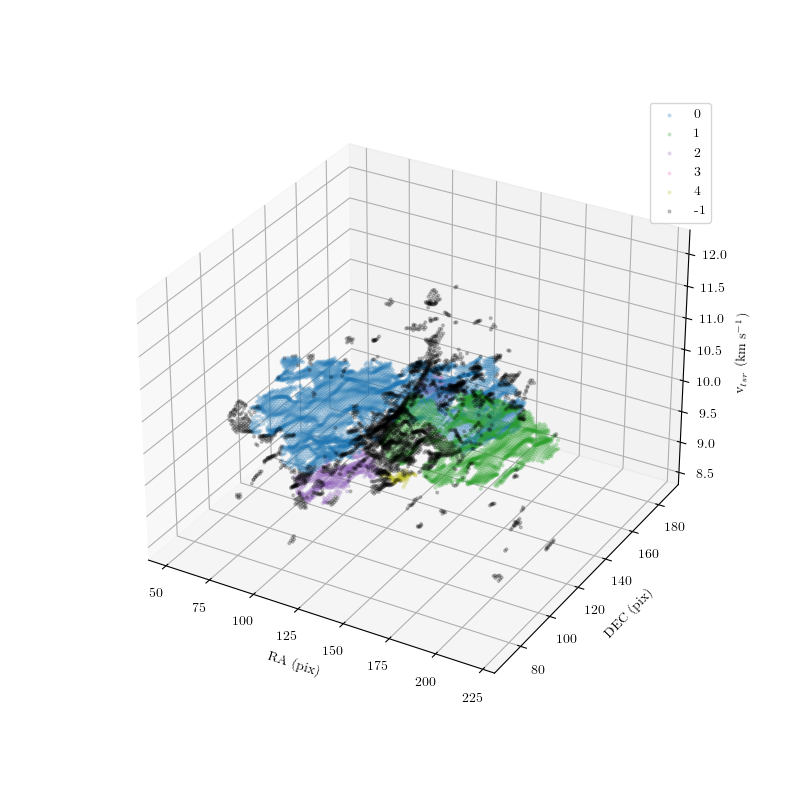

In [38]:
unique_labels = set(labels)
colors = [plt.cm.tab10(each) for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('RA (pix)')
ax.set_ylabel('DEC (pix)')
ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        # continue

    class_member_mask = labels == k

    xy = scaler.inverse_transform(X[class_member_mask])
    ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=col, alpha=0.2, label=k)
ax.legend()

In [39]:
# I want to plot only a couple of labels at a time
# labels_subset, colors_subset = [list(unique_labels)[-1], list(unique_labels)[3]], ['k', 'r']
# # labels_subset, colors_subset = list(unique_labels)[1:4], colors[1:4]
# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('RA (pix)')
# ax.set_ylabel('DEC (pix)')
# ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

# for k, col in zip(labels_subset, colors_subset):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]
#         #continue

#     class_member_mask = labels == k

#     xy = scaler.inverse_transform(X[class_member_mask])
#     ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=col, alpha=0.2, label=k)
# ax.legend()

In [40]:
ds_feats['labelsDBSCAN'] = labels
ds_feats.to_csv('DBSCAN_results.csv')

Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.


Text(0, 0.5, '$T_{MB}$ (K)')

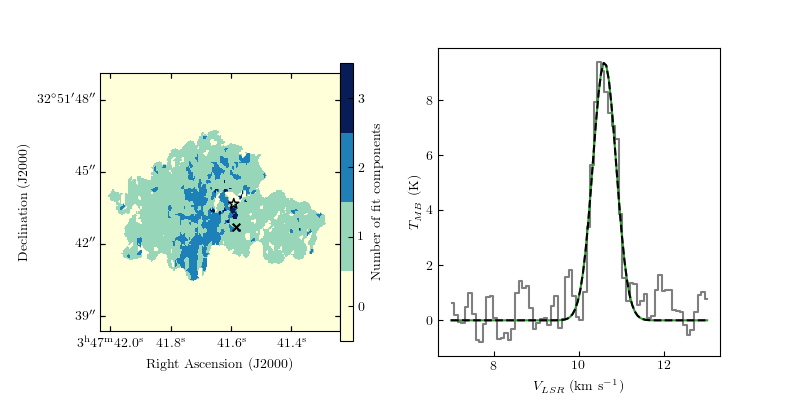

In [41]:
# we want to plot a map with the location of the spectra
posx, posy = 150, 113
velstart = 7 *u.km/u.s
velend = 13 *u.km/u.s
velsample = np.linspace(velstart.value, velend.value, 100)

ncompmap, headern = fits.getdata(fitfiletotalncomp, header=True)
ncompmap[np.where(np.isnan(ncompmap))] = 0
wcssky = WCS(headern)
cmap1 = copy(plt.cm.get_cmap("YlGnBu", 4))

cubedata = SpectralCube.read(cubefile+'.fits').spectral_slab(velstart,velend)
velocities = cubedata.spectral_axis
intensities = cubedata[:, posy, posx]
comppos = ds_feats[(ds_feats['x_pix'] == posx) & (ds_feats['y_pix'] == posy)]


fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121, projection=wcssky)
ax2 = fig.add_subplot(122)

sc1 = ax1.imshow(ncompmap, cmap=cmap1, vmin=-0.5, vmax=3.5)
cax = plt.colorbar(sc1, ax=ax1, label='Number of fit components', ticks=np.arange(4), pad=0, shrink=0.9)
ax1.scatter(posx, posy, marker='x', s=30, color='k')
ax1.set_xlim([45,230])
ax1.set_ylim([32,232])
ax1.set_xlabel(r'Right Ascension (J2000)')
ax1.set_ylabel(r'Declination (J2000)')
ax1.scatter(ra_yso, dec_yso, transform=ax1.get_transform('world'), marker='*', facecolor='None', edgecolor='k', s=60)
ax2.plot(velocities, intensities, drawstyle='steps-mid', color='k', alpha=0.5)
totalgauss = np.zeros(np.shape(velsample))
for index in comppos.index.values:
    g1 = Gaussian1D(comppos.loc[index, 'amplitude'], comppos.loc[index, 'vlsr'], comppos.loc[index, 'sigma_v'])
    labeldb = comppos.loc[index, 'labelsDBSCAN']
    totalgauss += g1(velsample)
    ax2.plot(velsample, g1(velsample), color='k' if labeldb==-1 else colors[labeldb])
ax2.plot(velsample, totalgauss, color='k', linestyle='dashed')

ax2.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax2.set_ylabel(r'$T_{MB}$ (K)') 

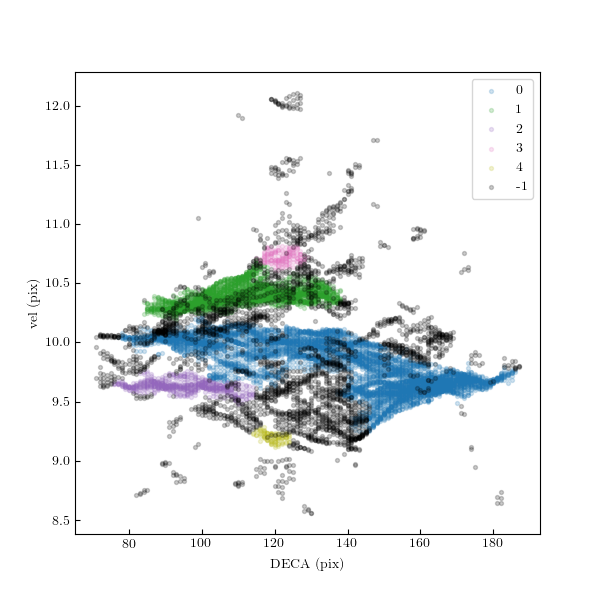

In [42]:
# we can also plot the groups two axis at a time

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('DECA (pix)')
ax.set_ylabel('vel (pix)')

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        #continue

    class_member_mask = labels == k

    xy = scaler.inverse_transform(X[class_member_mask])
    ax.scatter(xy[:,1], xy[:,2],  s=8, facecolor=col, edgecolor=col, alpha=0.2, label=k)
ax.legend()

In [43]:
# we save the features and labels together to plot them correctly

# labels_save = np.array(labels)[:, np.newaxis]
# dbscan_results = np.append(features_final, labels_save, axis=1)
# np.save('DBSCAN_results', dbscan_results)

Text(0.5, 0, 'v$_{lsr}$ (km s$^{-1}$)')

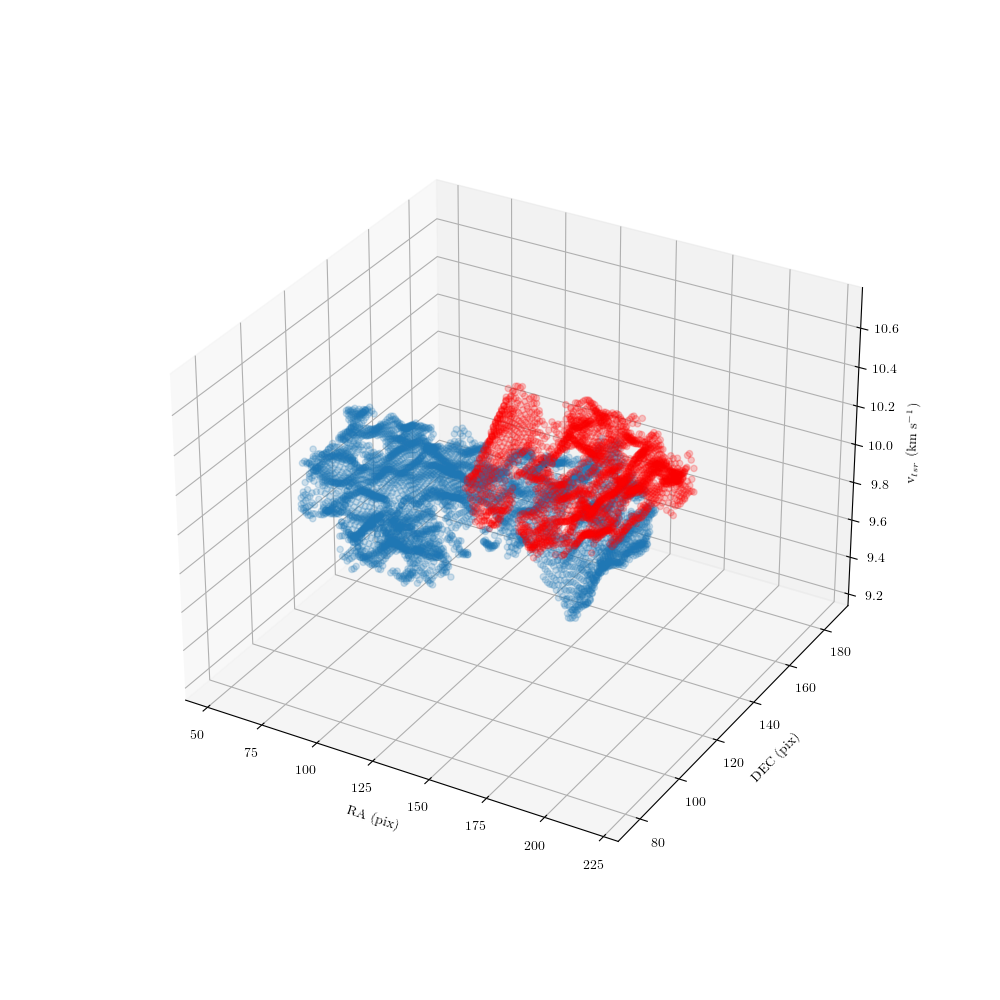

In [44]:
index_blue_env = np.where(labels == blue_label)
xx_blue = xx_props[index_blue_env]
yy_blue = yy_props[index_blue_env]
cent_velocities_blue = cent_velocities[index_blue_env]

index_red_env = np.where(labels == red_label)
xx_red = xx_props[index_red_env]
yy_red = yy_props[index_red_env]
cent_velocities_red = cent_velocities[index_red_env]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx_blue, yy_blue, cent_velocities_blue, alpha=0.2, color='C0')
ax.scatter(xx_red, yy_red, cent_velocities_red, alpha=0.2, color='r')
ax.scatter(147.20194, 128.35185, 10.2, marker='*', color='k', s=50)
ax.set_xlabel('RA (pix)')
ax.set_ylabel('DEC (pix)')
ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

In [45]:
if not os.path.exists(blue_env_paramsfile):
    
    e_cent_velocities_blue = e_cent_velocities[index_blue_env]
    amplitudes_blue = amplitudes[index_blue_env]
    e_amplitudes_blue = e_amplitudes[index_blue_env]
    sigma_vs_blue = sigma_vs[index_blue_env]
    e_sigma_vs_blue = e_sigma_vs[index_blue_env]

    # we can make a parameter cube with the errors and also an individual image
    envelope_blue_params = np.zeros(np.shape(fits.getdata(fitfile1G))) * np.nan
    flag_blue = np.zeros(np.shape(mask2d))
    envelope_blue_header = fits.getheader(fitfile1G)
    flag_blue_header = fits.getheader(mask2dfile)
    
    for i in range(len(xx_blue)):
        a, b = int(yy_blue[i]), int(xx_blue[i])
        if ~np.isnan(envelope_blue_params[0, a, b]): # if there is a repeated point
            flag_blue[a, b] = 1
            
        envelope_blue_params[0, a, b] = amplitudes_blue[i]
        envelope_blue_params[1, a, b] = cent_velocities_blue[i]
        envelope_blue_params[2, a, b] = sigma_vs_blue[i]
        envelope_blue_params[3, a, b] = e_amplitudes_blue[i]
        envelope_blue_params[4, a, b] = e_cent_velocities_blue[i]
        envelope_blue_params[5, a, b] = e_sigma_vs_blue[i]
        
    fits.writeto(blue_env_paramsfile, envelope_blue_params, envelope_blue_header)
    fits.writeto(flag_blue_env_file, flag_blue, flag_blue_header)
else:
    envelope_blue_params = fits.getdata(blue_env_paramsfile)
    flag_blue = fits.getdata(flag_blue_env_file)
    
if not os.path.exists(red_env_paramsfile):
    
    e_cent_velocities_red = e_cent_velocities[index_red_env]
    amplitudes_red = amplitudes[index_red_env]
    e_amplitudes_red= e_amplitudes[index_red_env]
    sigma_vs_red = sigma_vs[index_red_env]
    e_sigma_vs_red = e_sigma_vs[index_red_env]

    # we can make a parameter cube with the errors and also an individual image
    envelope_red_params = np.zeros(np.shape(fits.getdata(fitfile1G))) * np.nan
    flag_red = np.zeros(np.shape(mask2d))
    envelope_red_header = fits.getheader(fitfile1G)
    flag_red_header = fits.getheader(mask2dfile)
    
    for i in range(len(xx_red)):
        a, b = int(yy_red[i]), int(xx_red[i])
        if ~np.isnan(envelope_red_params[0, a, b]): # if there is a repeated point
            flag_red[a, b] = 1
            
        envelope_red_params[0, a, b] = amplitudes_red[i]
        envelope_red_params[1, a, b] = cent_velocities_red[i]
        envelope_red_params[2, a, b] = sigma_vs_red[i]
        envelope_red_params[3, a, b] = e_amplitudes_red[i]
        envelope_red_params[4, a, b] = e_cent_velocities_red[i]
        envelope_red_params[5, a, b] = e_sigma_vs_red[i]
        
    fits.writeto(red_env_paramsfile, envelope_red_params, envelope_red_header)
    fits.writeto(flag_red_env_file, flag_red, flag_red_header)
else:
    envelope_red_params = fits.getdata(red_env_paramsfile)
    flag_red = fits.getdata(flag_red_env_file)

In [46]:
blue_tpeakfile = blue_env_paramsfile[:-5] + '_Tpeak.fits'
blue_vlsrfile = blue_env_paramsfile[:-5] + '_vlsr.fits'
blue_sigmafile = blue_env_paramsfile[:-5] + '_sigmav.fits'
red_tpeakfile = red_env_paramsfile[:-5] + '_Tpeak.fits'
red_vlsrfile = red_env_paramsfile[:-5] + '_vlsr.fits'
red_sigmafile = red_env_paramsfile[:-5] + '_sigmav.fits'
base2dheader = fits.getheader(mask2dfile)

if not os.path.exists(blue_tpeakfile):
    base2dheader['BUNIT'] = 'K'
    fits.writeto(blue_tpeakfile, envelope_blue_params[0], base2dheader)
    
if not os.path.exists(blue_vlsrfile):
    base2dheader['BUNIT'] = 'km s-1'
    fits.writeto(blue_vlsrfile, envelope_blue_params[1], base2dheader)
    
if not os.path.exists(blue_sigmafile):
    base2dheader['BUNIT'] = 'km s-1'
    fits.writeto(blue_sigmafile, envelope_blue_params[2], base2dheader)
    
if not os.path.exists(red_tpeakfile):
    base2dheader['BUNIT'] = 'K'
    fits.writeto(red_tpeakfile, envelope_red_params[0], base2dheader)
    
if not os.path.exists(red_vlsrfile):
    base2dheader['BUNIT'] = 'km s-1'
    fits.writeto(red_vlsrfile, envelope_red_params[1], base2dheader)
    
if not os.path.exists(red_sigmafile):
    base2dheader['BUNIT'] = 'km s-1'
    fits.writeto(red_sigmafile, envelope_red_params[2], base2dheader)